# Predict the closing price, Model: SARIMAX, Stock Token: FPT, Train/Test/Validation/: 70/20/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price

----
### Model evaluation (Test set)
- RMSE: 1079.03
- MAE: 700.24
- MAPE: 0.91 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression


plt.style.use("default")

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> FPT - 7 2 1
split = 0  # 7 2 1
stock = 0  # FPT

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,19240,19270,19080,19270,590780,FPT
1,2019-03-04,19270,19520,19270,19440,806770,FPT
2,2019-03-05,19440,19520,19350,19390,824300,FPT
3,2019-03-06,19410,19480,19210,19270,695230,FPT
4,2019-03-07,19270,19440,19270,19330,374340,FPT
...,...,...,...,...,...,...,...
1308,2024-05-27,133000,133500,130600,132800,5157800,FPT
1309,2024-05-28,134000,137000,133100,137000,4625300,FPT
1310,2024-05-29,137100,138200,134800,135700,5837600,FPT
1311,2024-05-30,133800,135000,131900,135000,7261300,FPT


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [6]:
df.reset_index(drop=True)
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,56251.291698,56880.086824
std,27151.082839,27473.981127
min,19080.000000,19190.000000
25%,28120.000000,28410.000000
50%,62770.000000,63470.000000
75%,70940.000000,71450.000000
max,136100.000000,138000.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

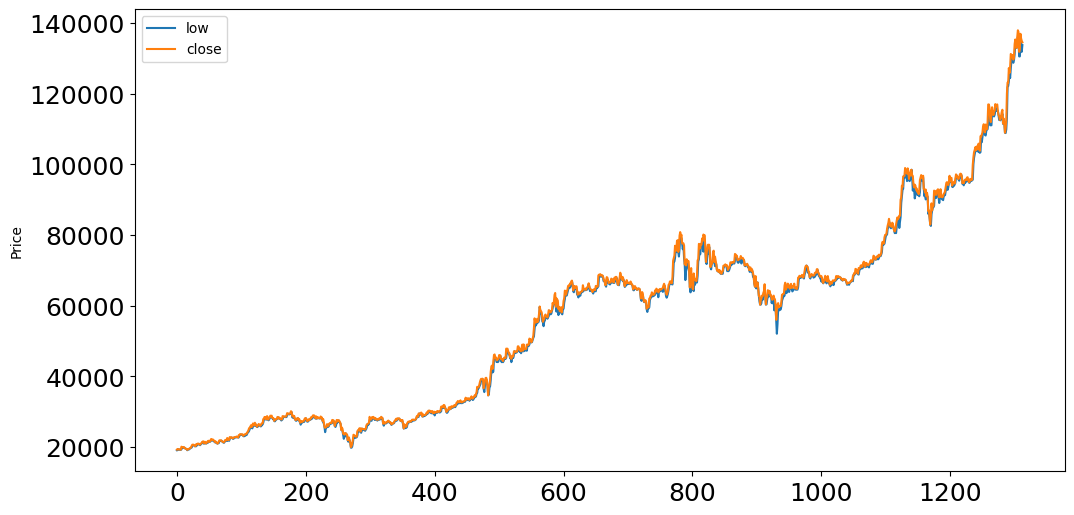

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(1.8386035496403492,
 0.9984225848793727,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 21624.1407585791)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.895
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.908
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


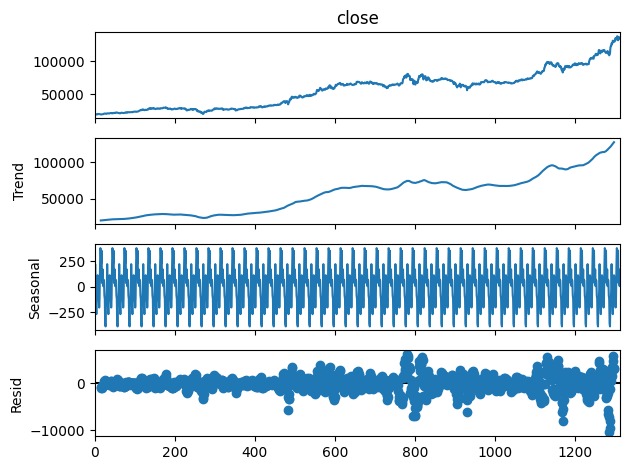

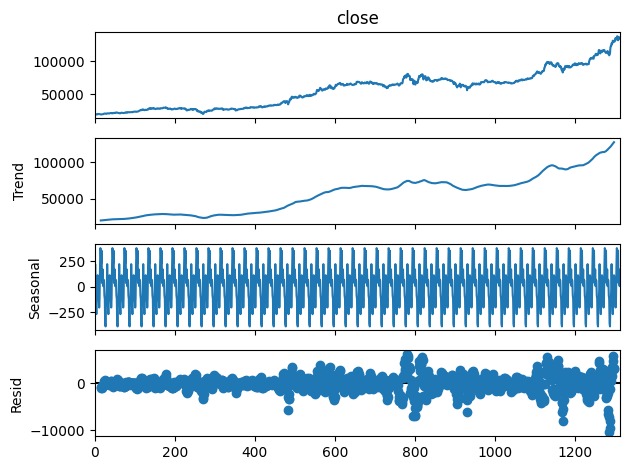

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-7.510879219513474,
 4.018716448015234e-11,
 20,
 897,
 {'1%': -3.4376611618861697,
  '5%': -2.864767502722044,
  '10%': -2.5684885413039127},
 14768.28656282628)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

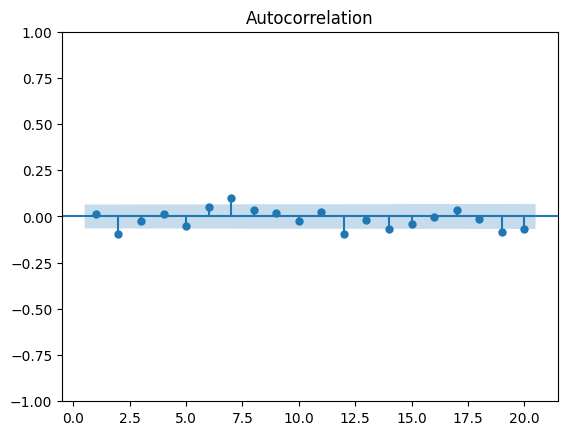

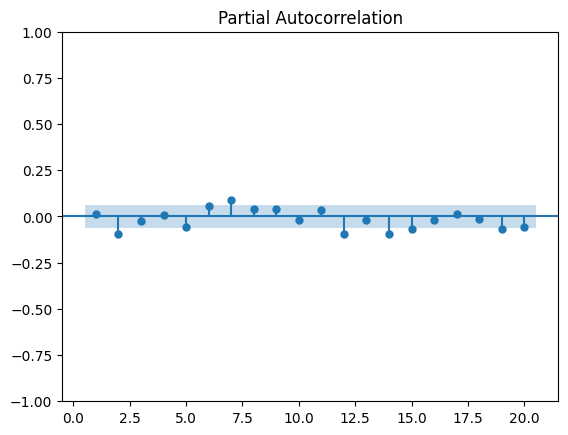

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=15130.942, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=15132.337, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=15132.147, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=15131.503, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=15130.585, Time=0.03 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=15131.864, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=15131.529, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=15130.436, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=15131.437, Time=0.05 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=15132.595, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=15132.180, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=15132.826, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[5]             : AIC=15131.473, Time=0.03 sec

Best model:  ARIMA(0,1,0

In [23]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -7562.218
Date:                             Mon, 03 Jun 2024   AIC                          15130.436
Time:                                     21:25:21   BIC                          15144.903
Sample:                                          0   HQIC                         15135.957
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     48.4205     29.349      1.650      0.099      -9.102     105.943
ma.S.L5       -0.0517      

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(1, 0, 2, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([63565.92875684, 64519.38421657, 63736.27731895, 63474.54285761,
       61730.79476403, 62598.68356805, 61607.82676337, 63165.63476487,
       59745.54734114, 62084.80182443, 60445.50038965, 57069.42366055,
       53231.5505115 , 55936.89487145, 59767.72133109, 60037.16694339,
       59709.7510653 , 60187.32147711, 59988.7608701 , 60850.02022098,
       62356.13133729, 62934.48822598, 63334.56906814, 63875.04336229,
       63744.00934983, 66574.45784559, 65417.96559295, 64416.826011  ,
       65121.67923325, 65565.55527878, 65747.23801726, 64757.22556417,
       65479.57791917, 65783.89387411, 65733.15638103, 65913.52335533,
       64923.43160876, 65158.19459259, 65451.61616281, 65567.61212464,
       65748.61913807, 65419.82339271, 65402.70565712, 65617.07608498,
       65403.01893398, 66080.46015132, 68148.70233829, 68881.98261913,
       68929.66374759, 68638.77869032, 68896.08937368, 69064.87853769,
       68882.93883005, 68763.95557153, 68474.14109594, 69568.81474765,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 91793.62258862,  90701.59298808,  89285.35976228,  90825.60023499,
        92072.15649144,  90962.74307052,  90380.9832779 ,  90263.44161098,
        90125.87068874,  91237.83413587,  91449.20966038,  91453.05348326,
        92699.67176975,  93827.07051178,  94161.09155885,  92911.03398352,
        93596.62023052,  94648.87454021,  95385.3928179 ,  95233.65004369,
        95249.47918752,  95058.34407734,  93773.33484603,  93729.38483725,
        94163.29431763,  94081.36170376,  94474.5678944 ,  94845.85138384,
        96456.56227564,  96891.67195664,  96322.36946584,  96131.07022676,
        95723.53559608,  95482.38886828,  96210.88377912,  96517.87601906,
        97105.72989041,  96601.19613103,  94605.62251475,  94750.83969173,
        94180.86147589,  94963.44594661,  94751.52011004,  95092.51580354,
        95238.85363935,  95739.9935253 ,  95840.67389238,  95434.3267825 ,
        94994.98765852,  94850.20867698,  95351.02948656,  95354.23176475,
        95435.28299343,  

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,19080,19270
1,19270,19440
2,19350,19390
3,19210,19270
4,19270,19330
...,...,...
1308,130600,132800
1309,133100,137000
1310,134800,135700
1311,131900,135000


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[102290.04656655 102238.83400398 102350.43806861 102398.99026657
 102543.47445023 102572.28211777 102641.72316117 102688.36207782
 102812.37578964 102822.26716399 102905.6111206  102976.23147656
 103023.37363977 103146.1043595  103157.2857377  103240.25735182
 103310.79177847 103358.37806586 103479.84452321 103492.28233258
 103574.88800948 103645.33753337 103693.3574915  103813.5880663
 103827.25382731 103909.50179702 103979.86831878 104028.31213935
 104147.33475641 104162.20071804]


### Plotting the data


In [34]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

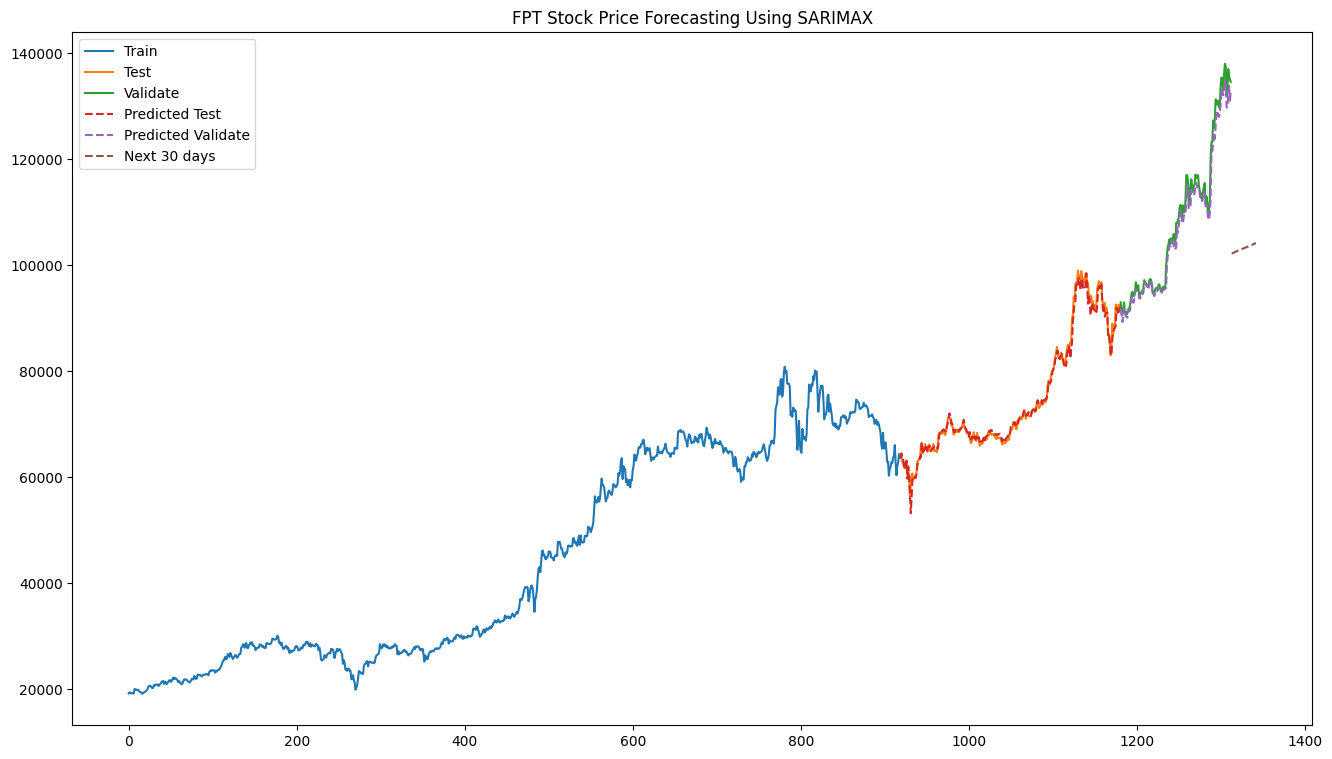

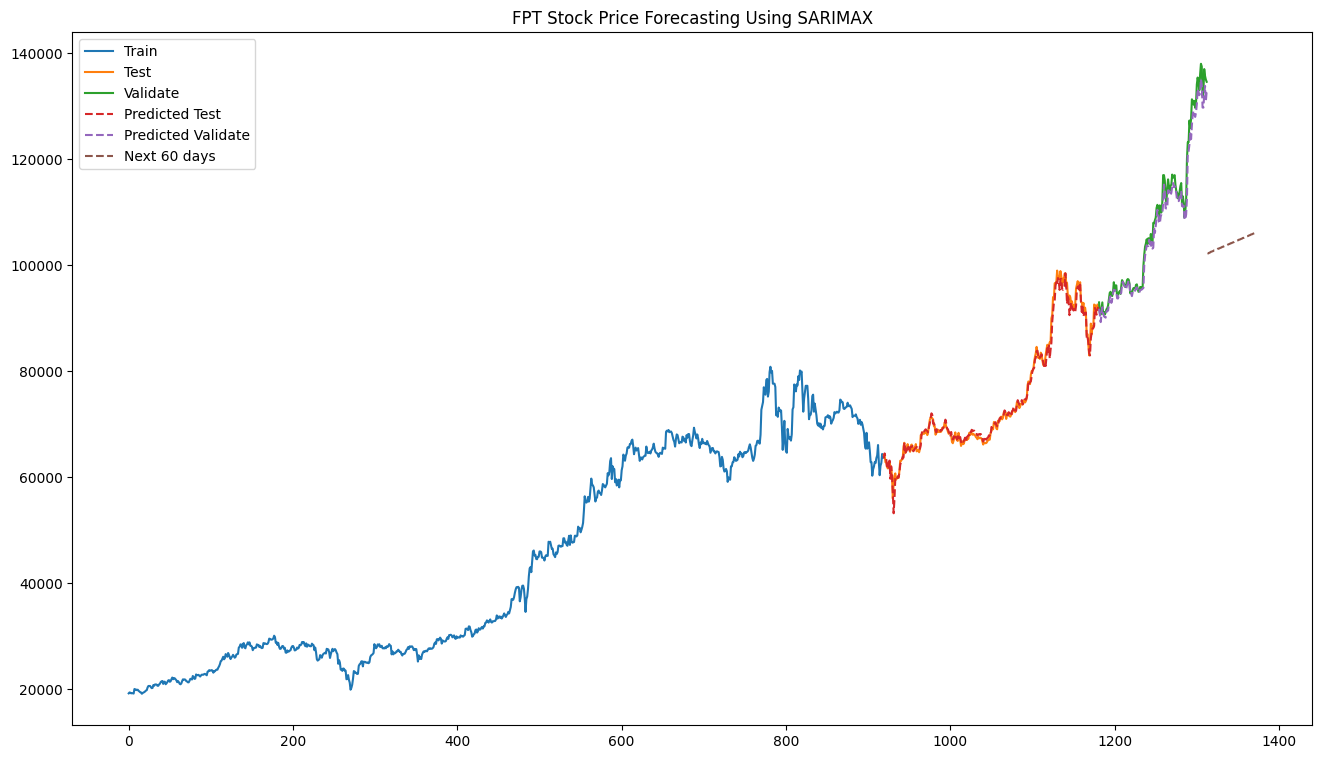

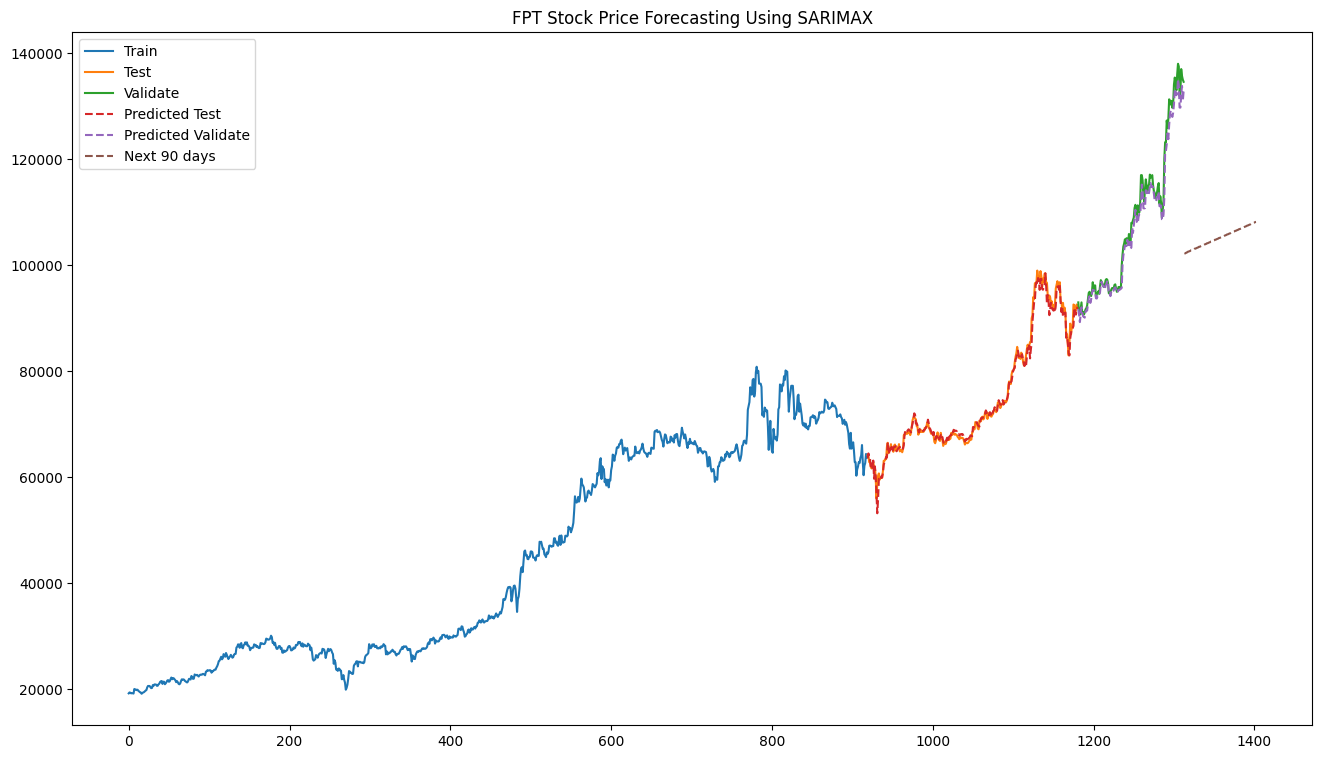

In [35]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 1079.0349688519568
MAE on test data: 700.2425724857861
MAPE on test data: 0.9157636224790636 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 1907.1661907712905
MAE on validation data: 1413.7000381538678
MAPE on validation data: 1.237981940441034 %
